<a href="https://www.kaggle.com/code/mehmetyusuf/large-scale-fish-classification-ann?scriptVersionId=202919099" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 1. Modülleri İçe Aktarma

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import random
from PIL import Image


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping



from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


import warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# 2. Veri Setini Yükleme

In [2]:
directory="/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset"

classes =  [i for i in os.listdir(path=directory) if "." not in i]
classes

['Hourse Mackerel',
 'Black Sea Sprat',
 'Sea Bass',
 'Red Mullet',
 'Trout',
 'Striped Red Mullet',
 'Shrimp',
 'Gilt-Head Bream',
 'Red Sea Bream']

In [3]:
label = [] 
path = []  

for dir_name, _, filenames in os.walk(directory):
    if dir_name.split()[-1] != "GT":
        for filename in filenames:
            if os.path.splitext(filename)[-1] == ".png":
                label.append(os.path.split(dir_name)[-1])
                path.append(os.path.join(dir_name, filename))

df = pd.DataFrame({
    "path": path,
    "label": label
})


# 3. Veri Setini İnceleme

In [4]:
df

path            label
0     /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
1     /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
2     /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
3     /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
4     /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
...                                                 ...              ...
8995  /kaggle/input/a-large-scale-fish-dataset/Fish_...    Red Sea Bream
8996  /kaggle/input/a-large-scale-fish-dataset/Fish_...    Red Sea Bream
8997  /kaggle/input/a-large-scale-fish-dataset/Fish_...    Red Sea Bream
8998  /kaggle/input/a-large-scale-fish-dataset/Fish_...    Red Sea Bream
8999  /kaggle/input/a-large-scale-fish-dataset/Fish_...    Red Sea Bream

[9000 rows x 2 columns]

In [5]:
print(f"Toplam dosya sayısı: {df.shape[0]}")

Toplam dosya sayısı: 9000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    9000 non-null   object
 1   label   9000 non-null   object
dtypes: object(2)
memory usage: 140.8+ KB


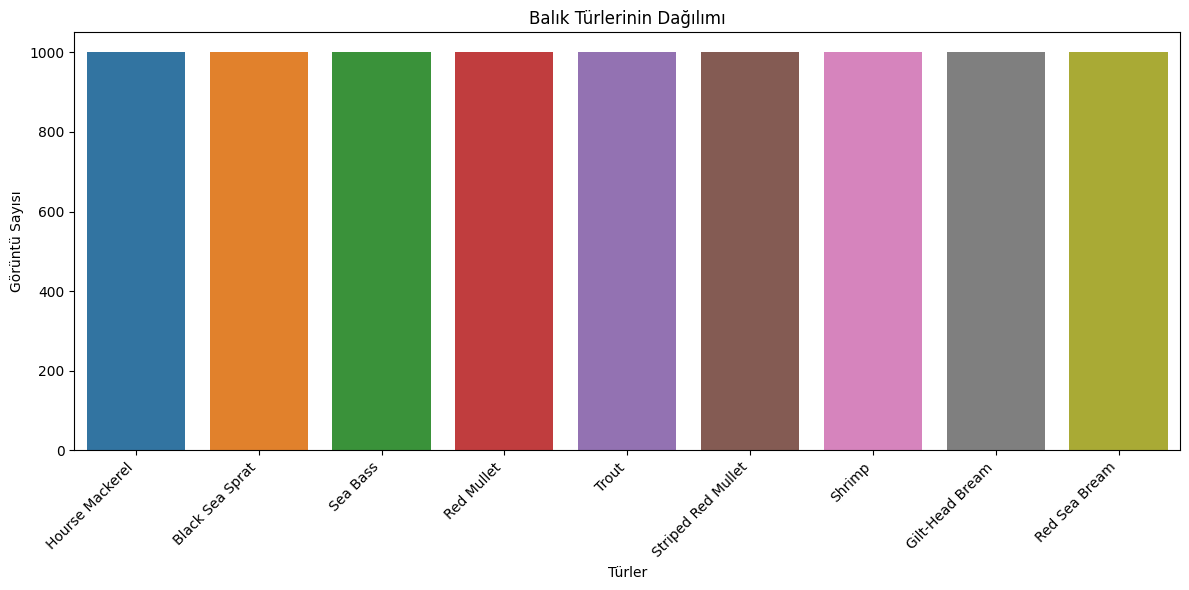

In [17]:
class_counts = df.label.value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Balık Türlerinin Dağılımı')
plt.xlabel('Türler')
plt.ylabel('Görüntü Sayısı')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

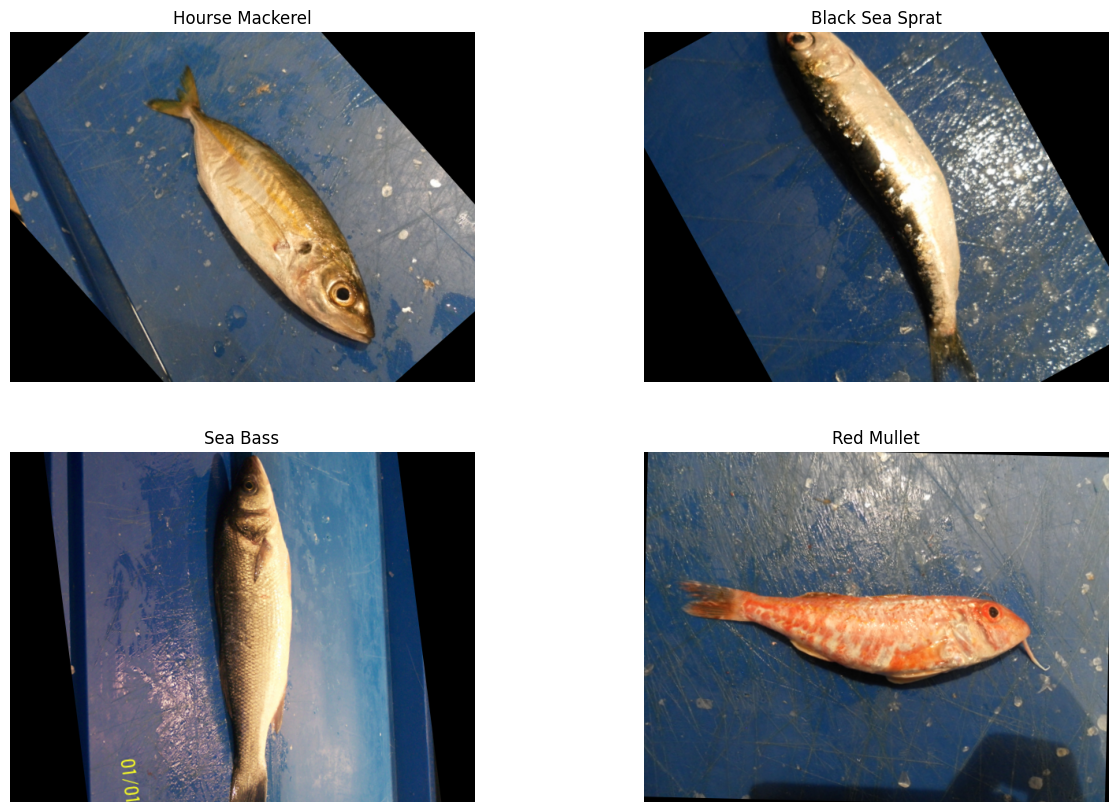

In [8]:
cn = 0  

plt.figure(figsize=(15, 10)) 

for unique_label in df['label'].unique()[:4]: 
    plt.subplot(2, 2, cn + 1)
    plt.imshow(plt.imread(df[df['label'] == unique_label].iloc[0, 0]))
    plt.title(unique_label)  
    plt.axis('off')  
    cn += 1

In [9]:
# Bu fonksiyon, belirtilen bir veri çerçevesinden (df) rastgele seçilen belirli sayıda (num_images) görüntüyü yükleyip ekrana getirir.
def visualize_random_images(df, num_images=4):
    plt.figure(figsize=(10, 5))

    for i in range(num_images):
        # Rastgele bir satır (görüntü) seç
        random_row = df.sample(n=1).iloc[0]  
        image_path = os.path.join(directory, random_row['path'])
        label = random_row['label']

        # Görüntüyü yükle ve göster
        plt.subplot(1, num_images, i+1)
        plt.imshow(plt.imread(image_path))
        plt.title(label)
        plt.axis('off')

    plt.show()

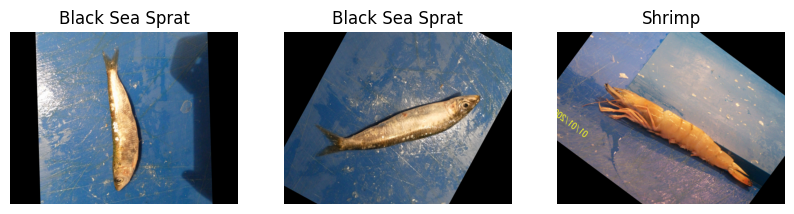

In [10]:
visualize_random_images(df, num_images=3)

In [21]:
# Bu fonksiyon, belirtilen bir veri çerçevesinden (df) belirli bir balık türüne (species) ait rastgele seçilmiş örnek görüntüleri gösterir.
def plot_sample_images_for_species(df, species, num_samples=5):
    image_column = 'path'
    label_column = 'label'
    
    species_df = df[df[label_column] == species]
    samples = species_df[image_column].values[:num_samples]
    plot_sample_images_for_species(df, "Shrimp", num_samples=5)
    plt.figure(figsize=(15, 3))
    
    for i, image_path in enumerate(samples):
        plt.subplot(1, num_samples, i + 1)
        
        img = Image.open(image_path)
        plt.imshow(img)
        plt.title(species)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


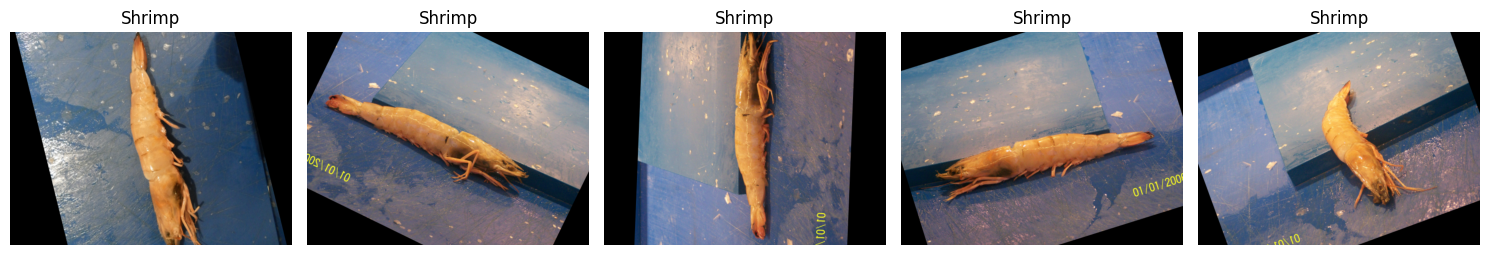

In [22]:
plot_sample_images_for_species(df, "Shrimp", num_samples=5)

#  4. Veri Ön İşleme

### 4.1 Train Test Validation Bölümü

In [24]:
# Veri setini eğitim, doğrulama ve test kümelerine ayırır.
train_data, test_data = train_test_split(df, test_size=0.15, random_state=42, stratify=df['label'])
train_data, val_data = train_test_split(train_data, test_size=0.1765, random_state=42, stratify=train_data['label'])

print(train_data.shape)
print(test_data.shape)
print(val_data.shape)

(6299, 2)
(1350, 2)
(1351, 2)


### 4.2 Verilerin Hazırlanması

In [ ]:
img_width, img_height = 128, 128
# Tüm görüntülerin genişliğini 128 piksel ve yüksekliğini 128 piksel olarak belirlendi.

In [52]:
# Bu fonksiyon veri setindeki görüntü dosya yollarını kullanarak resimleri yükler, ön işler ve ardından NumPy dizileri olarak döndürür.
"""Veri ön işlemede    
    RGB Dönüşümü
    Yeniden Boyutlandırma
    NumPy Dizisine Dönüştürme
    Normalizasyon
    Etiketleri Sayısallaştırma işlemlerini yapar
"""
def load_and_preprocess_images(df, img_width, img_height):
    images = []
    labels = []
    for index, row in df.iterrows():
        img = Image.open(row['path']).convert('RGB')
        img = img.resize((img_width, img_height))
        img = np.array(img) / 255.0  
        images.append(img)
        labels.append(classes.index(row['label']))  

    images = np.array(images)
    labels = np.array(labels)
    return images, labels

In [53]:
train_images, train_labels = load_and_preprocess_images(train_data, img_width, img_height)
test_images, test_labels = load_and_preprocess_images(test_data, img_width, img_height)
val_images, val_labels = load_and_preprocess_images(val_data, img_width, img_height)

In [54]:
# one-hot encoding yöntemini uygulayarak etiketleri kategorik verilere dönüştürür.
train_labels = to_categorical(train_labels, num_classes=len(classes))
test_labels = to_categorical(test_labels, num_classes=len(classes))
val_labels = to_categorical(val_labels, num_classes=len(classes))

### 4.3 Veri Setinden Örnek Görsellerin Görselleştirilmesi

In [83]:
def visualize_sample_images(images, labels, num_samples=5, dataset_name=""):
    plt.figure(figsize=(15, 3))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        if isinstance(images[i], str):
            img = Image.open(images[i])  
        else:
            img = images[i]
        plt.imshow(img)
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    
    plt.suptitle(f"{dataset_name} Kümesinden Örnek Resimler", fontsize=16)
    plt.tight_layout()
    plt.show()

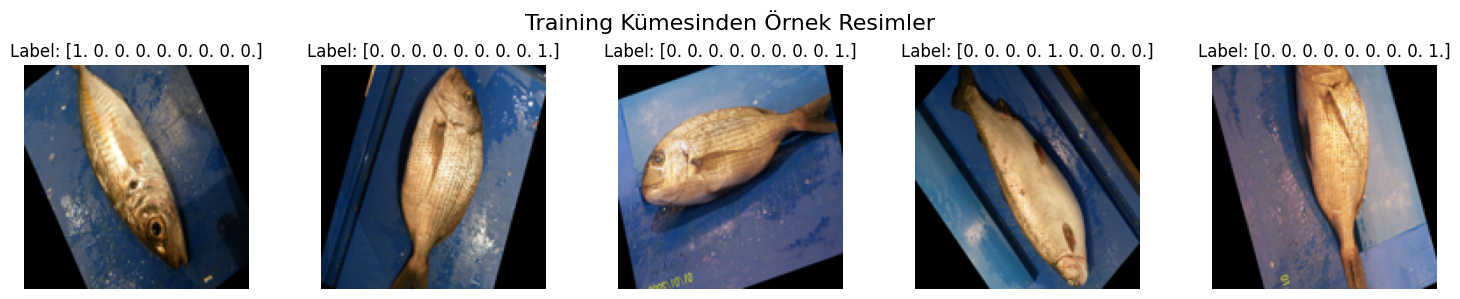

In [84]:
visualize_sample_images(train_images, train_labels, num_samples=5, dataset_name="Training")

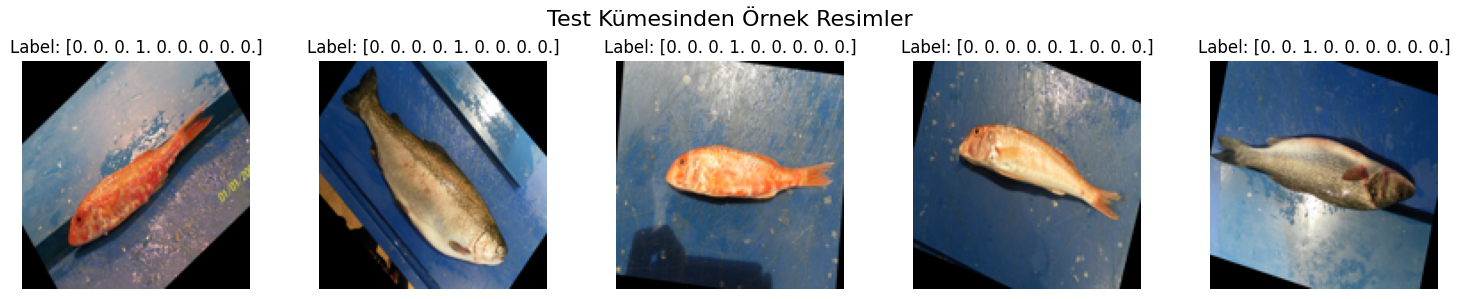

In [85]:
visualize_sample_images(test_images, test_labels, num_samples=5, dataset_name="Test")

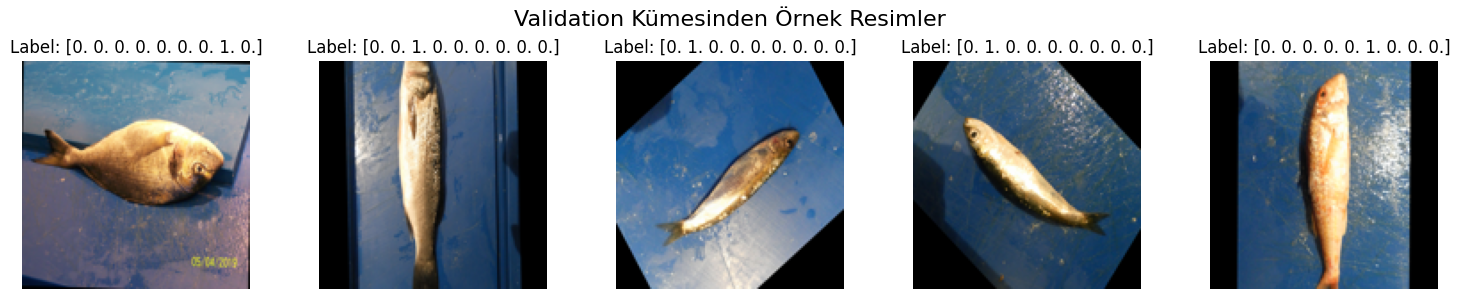

In [86]:
visualize_sample_images(val_images, val_labels, num_samples=5, dataset_name="Validation")

# 5. Modelleme

### 5.1 Derin Öğrenme | Model Mimarisi Tanımlama

In [69]:
model = Sequential()

# Giriş katmanı
model.add(Flatten(input_shape=(img_width, img_height, 3)))

# İlk katman 
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))  

# İkinci katman
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Üçüncü katman
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Dördüncü katman 
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Çıktı katmanı
model.add(Dense(len(classes), activation='softmax'))

### 5.2 Derin Öğrenme | Modelin Derlenmesi

In [70]:
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [71]:
# Modelin gereksiz yere uzun süre eğitilmesini ve aşırı öğrenmeyi önlemek için erken durdurma tekniğini kullanmak üzere bir yapılandırma oluşturur.
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [72]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1024)           │    50,332,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,030,537 (194.67 MB)

 Trainable params: 51,026,697 (194.65 MB)

 Non-trainable params: 3,840 (15.00 KB)

### 5.3 Derin Öğrenme | Modeli Eğitimi

In [73]:
# Modeli eğitme
history = model.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    epochs=50,
                    batch_size=16,
                    callbacks=[early_stopping])


Epoch 1/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - accuracy: 0.2669 - loss: 2.2608 - val_accuracy: 0.5130 - val_loss: 1.3673
Epoch 2/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4635 - loss: 1.5566 - val_accuracy: 0.5522 - val_loss: 1.4458
Epoch 3/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5357 - loss: 1.3732 - val_accuracy: 0.7032 - val_loss: 0.8805
Epoch 4/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5923 - loss: 1.2128 - val_accuracy: 0.7246 - val_loss: 0.7798
Epoch 5/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6372 - loss: 1.0606 - val_accuracy: 0.7461 - val_loss: 0.7372
Epoch 6/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6785 - loss: 0.9673 - val_accuracy: 0.7987 - val_loss: 0.6122
Epoch 7/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7054 - loss: 0.8782 - val_accuracy: 0.7654 - val_loss: 0.6987
Epoch 8/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7266 - loss: 0.8060 - val_accuracy: 

# 6. Model Performansı ve Değerlendirme Metrikleri

In [82]:
print("\nEğitim Loss:", history.history['loss'][-1])
print("Validasyon Loss:", history.history['val_loss'][-1])

print("\nEğitim Accuracy:", history.history['accuracy'][-1])
print("Validasyon Accuracy:", history.history['val_accuracy'][-1])


Eğitim Loss: 0.2817555367946625
Validasyon Loss: 0.24207203090190887

Eğitim Accuracy: 0.9074456095695496
Validasyon Accuracy: 0.9156180620193481


### 6.1 Doğruluk Grafiği

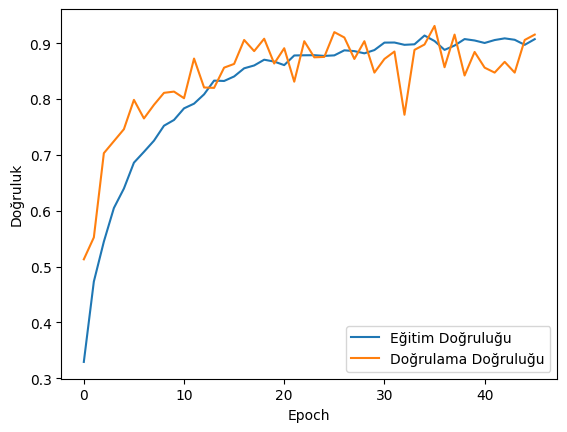

In [74]:
# Eğitim ve doğrulama doğruluğunu çizdir
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.show()


### 6.2 Kayıp Grafiği

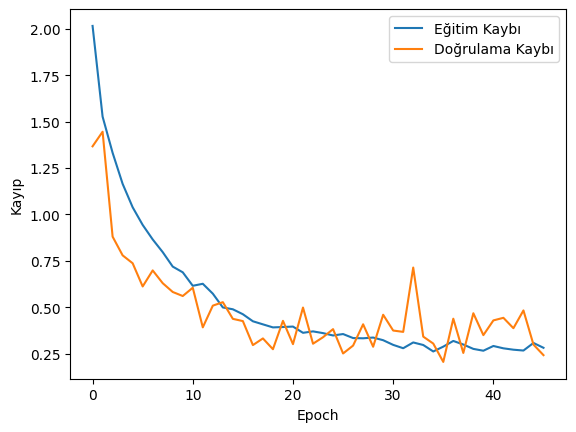

In [75]:
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.show()

### 6.3 Sınıflandırma Sonuçları: Karışıklık Matrisi

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
                    precision    recall  f1-score   support

   Hourse Mackerel       0.92      0.98      0.95       150
   Black Sea Sprat       0.87      0.97      0.92       150
          Sea Bass       0.96      0.76      0.85       150
        Red Mullet       0.95      0.99      0.97       150
             Trout       0.90      0.93      0.91       150
Striped Red Mullet       0.87      0.95      0.91       150
            Shrimp       0.95      0.97      0.96       150
   Gilt-Head Bream       0.94      0.87      0.91       150
     Red Sea Bream       0.99      0.93      0.96       150

          accuracy                           0.93      1350
         macro avg       0.93      0.93      0.93      1350
      weighted avg       0.93      0.93      0.93      1350



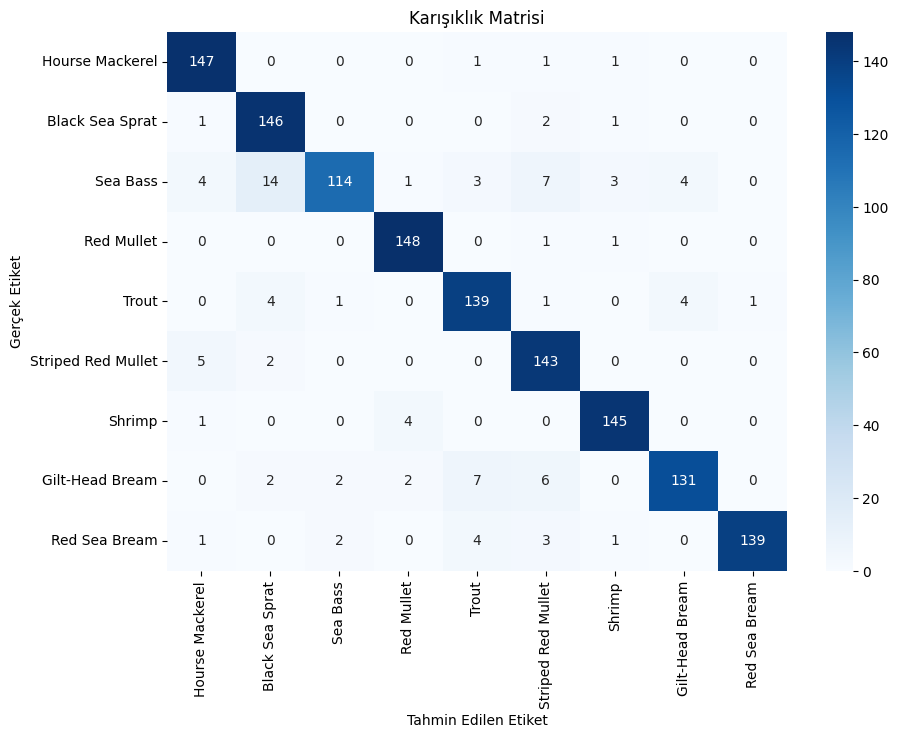

In [80]:
predictions = model.predict(test_images)

predicted_classes = np.argmax(predictions, axis=1)

true_classes = np.argmax(test_labels, axis=1)

y_true_labels = np.argmax(test_labels, axis=1)  # Gerçek etiketler
y_pred_labels = predicted_classes  # Tahmin edilen etiketler

print(classification_report(y_true_labels, y_pred_labels, target_names=classes))

cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.ylabel('Gerçek Etiket')
plt.xlabel('Tahmin Edilen Etiket')
plt.title('Karışıklık Matrisi')
plt.show()


# 7. Test Verileri Üzerinde Sınıf Tahminleri

In [79]:
for i in range(10):
    print(f"Gerçek sınıf: {classes[true_classes[i]]}, Tahmin edilen: {classes[predicted_classes[i]]}")

Gerçek sınıf: Red Mullet, Tahmin edilen: Red Mullet
Gerçek sınıf: Trout, Tahmin edilen: Trout
Gerçek sınıf: Red Mullet, Tahmin edilen: Red Mullet
Gerçek sınıf: Striped Red Mullet, Tahmin edilen: Striped Red Mullet
Gerçek sınıf: Sea Bass, Tahmin edilen: Sea Bass
Gerçek sınıf: Trout, Tahmin edilen: Trout
Gerçek sınıf: Shrimp, Tahmin edilen: Red Mullet
Gerçek sınıf: Shrimp, Tahmin edilen: Shrimp
Gerçek sınıf: Striped Red Mullet, Tahmin edilen: Striped Red Mullet
Gerçek sınıf: Sea Bass, Tahmin edilen: Sea Bass


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


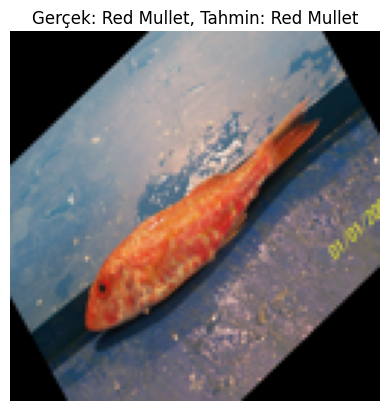

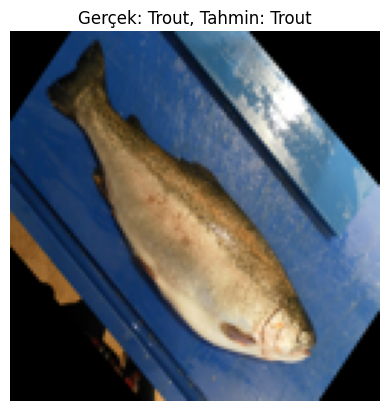

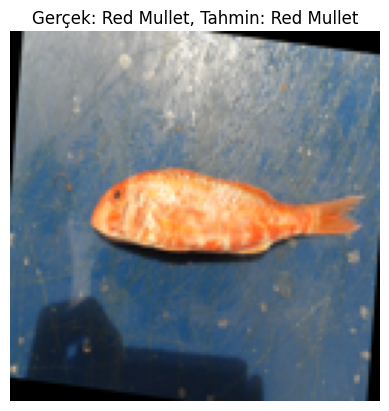

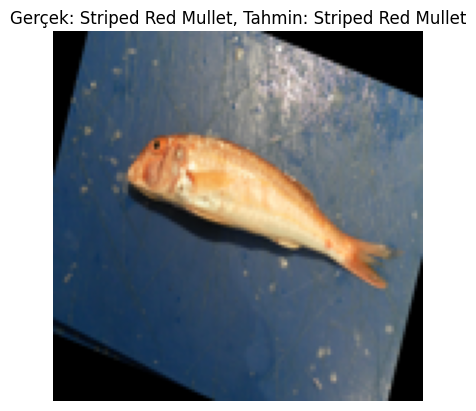

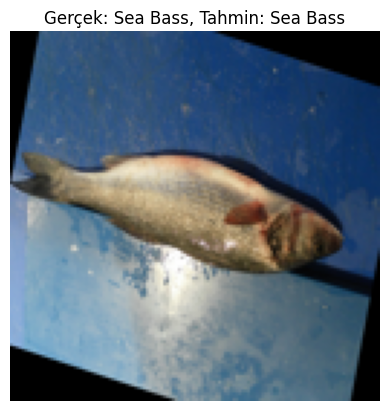

In [78]:
import matplotlib.pyplot as plt

predictions = model.predict(test_images)

predicted_classes = np.argmax(predictions, axis=1)

true_classes = np.argmax(test_labels, axis=1)

for i in range(5):
    plt.imshow(test_images[i])
    plt.title(f"Gerçek: {classes[true_classes[i]]}, Tahmin: {classes[predicted_classes[i]]}")
    plt.axis('off')  
    plt.show()
